# Wine Classification and Regression

In this lab, we'll go over all the concepts we've learned in the fundamentals module.
We'll work with the Wine dataset we saw in the Data API lab.
To complete this lab, you may use torch, fastai, or pytorch-lightning.
We will be building 3 models:
* One that classifies wine into white/red
* One that predicts wine quality
* One that predicts both red/white and wine quality (extra credit)

To practice different ways of implementing training, try to use `fastai` for one of your models, and `pytorch_lightning` for a different one.

**NOTE:** If you decide to use fastai, you should make sure to upgrade fastai.
Colab contains a rather outdated version.

## Setup

This section downloads and loads the dataset.
No work is required here.

In [1]:
import pandas as pd

In [2]:
# Download the data
!rm -r *.csv
!rm -r *.names
URLS = [
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names'
]
for url in URLS:
    !wget {url}

--2021-10-13 16:46:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.1s    

2021-10-13 16:46:23 (815 KB/s) - ‘winequality-red.csv’ saved [84199/84199]

--2021-10-13 16:46:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[======

In [3]:
red = pd.read_csv('winequality-red.csv', delimiter=';')
red['is_red'] = 1
white = pd.read_csv('winequality-white.csv', delimiter=';')
white['is_red'] = 0
wine = red.append(white).reset_index(drop=True)

## Create a model to classify red vs. white wine

#### Instructions

In this section, use either base `torch`, `fastai`, or `pytorch_lightning` to classify red vs. white wines.
Section headers will be provided where you will:
* Split your data into train and validation datasets
* Create your `WineDataset` class and create train and validation dataloaders
* Train your model
* Evaluate your model

Note that this dataset is **imbalanced.** 
Make sure to evaluate your model using at least one classification metric that is robust to class imbalance.
Does your model outperform random chance?

In [4]:
!pip install -Uqq pytorch-lightning torchmetrics

#### Imports

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
from torch import nn, optim
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import torchmetrics as metrics
import numpy as np
from sklearn import metrics as skm

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Preparation

In this secition...
* Split your data into train and validation datasets
* Create your `Dataset` class. It should return the `is_red` feature as the label.
* Create train/valid dataloaders (base `torch`), a `pl.Datamodule` (`pytorch_lightning`), or a `DataLoaders` object (`fastai`)

**HINT:** Don't forget to build feature scaling into your dataset *or* model somewhere!
It doesn't necessarly have to be in your `Dataset`, you can also use a layer we've previously learned about to do this as the first layer in your model.

In [8]:
train, valid = train_test_split(wine, test_size=0.1, stratify=wine.is_red)

In [9]:
Y_COLS = ['quality', 'is_red']
X_COLS = train.drop(Y_COLS, axis=1).columns.tolist()

In [10]:
class WineDataset(Dataset):
    def __init__(self, df, y_col='quality'):
        super().__init__()
        self.df = df
        self.y_col = y_col

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        return self.df[X_COLS].iloc[idx].values.astype(np.float32), self.df[self.y_col].iloc[idx]

In [11]:
class WineClfDataModule(pl.LightningDataModule):
    def __init__(self, train_df, valid_df, batch_size=256):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(WineDataset(self.train_df, 'is_red'), batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(WineDataset(self.valid_df, 'is_red'), batch_size=self.batch_size)

In [12]:
clf_dm = WineClfDataModule(train, valid)

#### Build your model

In [13]:
def linear(in_dim, out_dim, dropout=0.5):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.ReLU(),
        nn.Dropout(),
        nn.BatchNorm1d(out_dim)
    )

In [14]:
class WineClassifierModel(pl.LightningModule):
    def __init__(self, n_hidden=2, hidden_dim=32, dropout=0.5):
        super().__init__()
        self.n_hidden = n_hidden
        self.hidden_dim = hidden_dim
        self.dropout = dropout

        self.model = nn.Sequential(
            nn.BatchNorm1d(len(X_COLS)),
            linear(len(X_COLS), self.hidden_dim),
            *(linear(self.hidden_dim, self.hidden_dim) for _ in range(self.n_hidden - 1)),
            linear(self.hidden_dim, 1)
        )

        self.loss = nn.BCEWithLogitsLoss()
        self.train_auc = metrics.AUROC(pos_label=1)
        self.valid_auc = metrics.AUROC(pos_label=1)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x).squeeze()
        probas = yhat.sigmoid()
        loss = self.loss(yhat, y.float())
        auc = self.train_auc(probas, y)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_roc_auc', auc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x).squeeze()
        probas = yhat.sigmoid()
        loss = self.loss(yhat, y.float())
        auc = self.valid_auc(probas, y)

        self.log('valid_loss', loss, prog_bar=True)
        self.log('valid_roc_auc', auc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [15]:
model = WineClassifierModel()

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


#### Train your model

In [16]:
cbs = [pl.callbacks.EarlyStopping('valid_loss', patience=2)]

In [17]:
trainer = pl.Trainer(gpus=torch.cuda.device_count(), callbacks=cbs, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
trainer.fit(model, datamodule=clf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Sequential        | 1.6 K 
1 | loss      | BCEWithLogitsLoss | 0     
2 | train_auc | AUROC             | 0     
3 | valid_auc | AUROC             | 0     
------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### Evaluate your model

In [19]:
logits = []
ys = []
for x_b, y_b in clf_dm.val_dataloader():
    with torch.inference_mode():
        logits.append(model.eval()(x_b.to(model.device)).squeeze().sigmoid())
        ys.append(y_b)

In [20]:
probas = torch.cat(logits, dim=0).cpu().numpy()
ys = torch.cat(ys, dim=0).cpu().numpy()

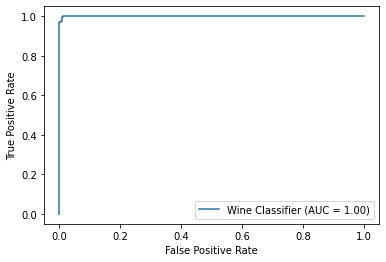

In [21]:
fpr, tpr, thresholds = skm.roc_curve(ys, probas)
roc_auc = skm.auc(fpr, tpr)
skm.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Wine Classifier').plot()

## Create a regression model to predict wine quality

#### Instructions

In this section, use either base `torch`, `fastai`, or `pytorch_lightning` to classify red vs. white wines.
Make sure you use a framework not used in the previous section.
Section headers will be provided where you will:
* Split your data into train and validation datasets. If you intend to use splits from before, you no work is required here.
* Create your `WineDataset` class and create train and validation dataloaders
* Train your model
* Evaluate your model

Make sure to use at least 2 regression metrics to evaluate your model!

In [22]:
!pip install -Uqq fastai

In [23]:
from fastai import *
from fastai.tabular.all import *

#### Data Preparation

In this secition...
* Split your data into train and validation datasets.
* Create your `Dataset` class. It should return values for features and the `quality` feature as the label.
* Create train/valid dataloaders (base `torch`), a `pl.Datamodule` (`pytorch_lightning`), or a `DataLoaders` object (`fastai`)

**HINT:** Don't forget to build feature scaling into your dataset *or* model somewhere!
It doesn't necessarly have to be in your `Dataset`, you can also use a layer we've previously learned about to do this as the first layer in your model.

In [24]:
train_ds = WineDataset(train)
valid_ds = WineDataset(valid)

In [25]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

#### Build your model

In [26]:
model = nn.Sequential(
    nn.BatchNorm1d(11),
    linear(11, 64),
    *(linear(64, 64) for _ in range(2)),
    nn.Linear(64, 1)
)

#### Train your model

In [27]:
loss = MSELossFlat()

In [28]:
learn = Learner(dls, model, loss)

In [29]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,34.991337,35.173065,00:04
1,31.799662,27.967218,00:04
2,18.582808,8.745086,00:04
3,7.132382,0.995966,00:04
4,3.735256,0.603908,00:04
5,2.660937,0.598315,00:04
6,2.391101,0.546889,00:04
7,2.183445,0.538905,00:04
8,2.044799,0.548571,00:04
9,2.085458,0.538166,00:04


#### Evaluate your model

In [30]:
_, preds, ys = learn.get_preds(dl=dls.valid, with_input=True, )

In [31]:
preds = preds.squeeze().detach().cpu().numpy()
ys = ys.numpy() 

In [32]:
skm.r2_score(ys, preds)

0.26201859032896535

In [33]:
skm.r2_score(ys, np.ones_like(ys) * ys.mean())

0.0

In [34]:
skm.mean_squared_error(ys, preds)

0.5381657378586614

## Extra credit: Create a model that predicts wine quality **and** whether it's red!

#### Instructions

In this section, use either base `torch`, `fastai`, or `pytorch_lightning` to classify red vs. white wines.
Make sure you use a framework not used in the previous section.
Section headers will be provided where you will:
* Split your data into train and validation datasets. If you intend to use splits from before, you no work is required here.
* Create your `WineDataset` class and create train and validation dataloaders
* Train your model
* Evaluate your model

Make sure to use at least 2 regression metrics to evaluate your model!

#### Data Preparation

In this secition...
* Split your data into train and validation datasets.
* Create your `Dataset` class. It should return values for features and the `quality` feature as the label.
* Create train/valid dataloaders (base `torch`), a `pl.Datamodule` (`pytorch_lightning`), or a `DataLoaders` object (`fastai`)

**HINT:** Don't forget about feature scaling!

**HINT:** Your `Dataset` object should return 3 things (`x, y1, y2`) instead of just one Y variable.

In [35]:
class WineTwoTaskDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        return self.df[X_COLS].iloc[idx].values.astype(np.float32), self.df['quality'].iloc[idx], self.df['is_red'].iloc[idx]

In [36]:
train_ds = WineTwoTaskDataset(train)
valid_ds = WineTwoTaskDataset(valid)

In [37]:
train_dl = DataLoader(train_ds, batch_size=64)
valid_dl = DataLoader(valid_ds, batch_size=64)

#### Build your model

In previous cases, you could use the `nn.Sequential` API to build your model.
In this case, you'll need to use the subclassing method.

**HINT:** Your model should take 1 input but provide 2 outputs. You can have a shared "backbone" that processes the input data into some hidden representation, but have multiple layers or networks where the inputs are both the output of the backbone. Your model should return the outputs of those 2 layers/networks as a tuple.

In [38]:
class WineTwoTaskModel(nn.Module):
    def __init__(self, n_hidden_layers=2, n_units=64, dropout=0.3):
        super().__init__()
        self.n_hidden_layers, self.n_units, self.dropout = n_hidden_layers, n_units, dropout

        self.backbone = nn.Sequential(
            nn.BatchNorm1d(11),
            linear(11, self.n_units),
            *(linear(self.n_units, self.n_units, self.dropout) for _ in range(self.n_hidden_layers - 1))
        )

        self.reg_output = nn.Linear(self.n_units, 1)
        self.clf_output = nn.Linear(self.n_units, 1)

    def forward(self, x):
        x = self.backbone(x)
        return self.reg_output(x), self.clf_output(x)

#### Train and evaluate your model

In [39]:
# Instantiate metrics
auc = metrics.AUROC()
r2 = metrics.R2Score()

reg_loss = nn.MSELoss()
clf_loss = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [40]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [41]:
model = WineTwoTaskModel().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [42]:
N_EPOCHS = 20

In [43]:
for i in range(N_EPOCHS):
    train_rls = []
    train_cls= []
    model.train()
    for x, ry, cy in train_dl:
        # Get outputs
        x, ry, cy = x.to(DEVICE), ry.to(DEVICE), cy.to(DEVICE)
        reg_preds, logits = model(x)
        reg_preds.squeeze_()
        logits.squeeze_()
        probas = logits.sigmoid()
        # Calculate and record regression loss
        rl = reg_loss(reg_preds, ry.squeeze().float())
        train_rls.append(rl.item())
        # Calculate and record clf loss
        cl = clf_loss(logits, cy.squeeze().float())
        train_cls.append(cl.item())
        # Combine losses
        loss = rl + cl
        # Backpropagate
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Record metrics
        _auc = auc(probas.cpu(), cy.cpu())
        _r2 = r2(reg_preds.cpu(), ry.cpu())
    
    epoch_train_rl = np.mean(train_rls)
    epoch_train_cl = np.mean(train_cls)
    epoch_train_auc = auc.compute()
    epoch_train_r2 = r2.compute()

    valid_rls = []
    valid_cls= []
    model.eval()
    for x, ry, cy in valid_dl:
        x, ry, cy = x.to(DEVICE), ry.to(DEVICE), cy.to(DEVICE)
        # Get outputs
        with torch.no_grad():
            reg_preds, logits = model(x)
        reg_preds.squeeze_()
        logits.squeeze_()
        probas = logits.sigmoid()
        # Calculate and record regression loss
        rl = reg_loss(reg_preds, ry.squeeze().float())
        valid_rls.append(rl.item())
        # Calculate and record clf loss
        cl = clf_loss(logits, cy.squeeze().float())
        valid_cls.append(cl.item())

        # Record metrics
        _auc = auc(probas.cpu(), cy.cpu())
        _r2 = r2(reg_preds.cpu(), ry.cpu())
    
    epoch_valid_rl = np.mean(valid_rls)
    epoch_valid_cl = np.mean(valid_cls)
    epoch_valid_auc = auc.compute()
    epoch_valid_r2 = r2.compute()

    print(f"""
    Epoch {i}
    Classification Loss - Train: {epoch_train_cl:.03f}, Valid: {epoch_valid_cl:.03f}
    ROC AUC - Train: {epoch_train_auc:.03f}, Valid: {epoch_valid_auc:.03f}
    Regression Loss - Train: {epoch_train_rl:.03f}, Valid: {epoch_valid_rl:.03f}
    R2 Score - Train: {epoch_train_r2:.03f}, Valid: {epoch_valid_r2:.03f}
    """)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)



    Epoch 0
    Classification Loss - Train: 0.507, Valid: 0.316
    ROC AUC - Train: 0.893, Valid: 0.909
    Regression Loss - Train: 31.939, Valid: 25.820
    R2 Score - Train: -40.740, Valid: -40.137
    

    Epoch 1
    Classification Loss - Train: 0.286, Valid: 0.165
    ROC AUC - Train: 0.948, Valid: 0.953
    Regression Loss - Train: 16.434, Valid: 6.703
    R2 Score - Train: -30.823, Valid: -29.738
    

    Epoch 2
    Classification Loss - Train: 0.191, Valid: 0.114
    ROC AUC - Train: 0.959, Valid: 0.961
    Regression Loss - Train: 4.780, Valid: 0.753
    R2 Score - Train: -22.115, Valid: -21.411
    

    Epoch 3
    Classification Loss - Train: 0.162, Valid: 0.094
    ROC AUC - Train: 0.964, Valid: 0.965
    Regression Loss - Train: 2.867, Valid: 0.623
    R2 Score - Train: -17.084, Valid: -16.671
    

    Epoch 4
    Classification Loss - Train: 0.146, Valid: 0.081
    ROC AUC - Train: 0.968, Valid: 0.969
    Regression Loss - Train: 2.336, Valid: 0.572
    R2 Score 